In [15]:
# adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

import pandas as pd

df_regulation = pd.read_parquet("../data/regulation_pbp.parquet")
df_regulation.rename(columns={"time_remaining": "seconds_elapsed"}, inplace=True)
df_reg_ot = pd.read_parquet("../data/regular_ot_pbp.parquet")
df_ply_ot = pd.read_parquet("../data/playoff_ot_pbp.parquet")

df = pd.concat([df_regulation, df_reg_ot, df_ply_ot], ignore_index=True)
df.drop("seconds_elapsed", axis=1, inplace=True)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import meter

window_size = 3

df = meter.plays_preceding_goals(df, window_size, convert_winner=True)
one_hot = pd.get_dummies(df, columns=["event", "team", "event_zone", "home_zone", "strength"])

X, y = meter.meter_game_pbp(one_hot, window_size)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, train_size=0.8, random_state=42
)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Input
from keras.models import Sequential
from matplotlib import pyplot

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential([
    Input(shape=(window_size, X.shape[2])),
    LSTM(16),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam')

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

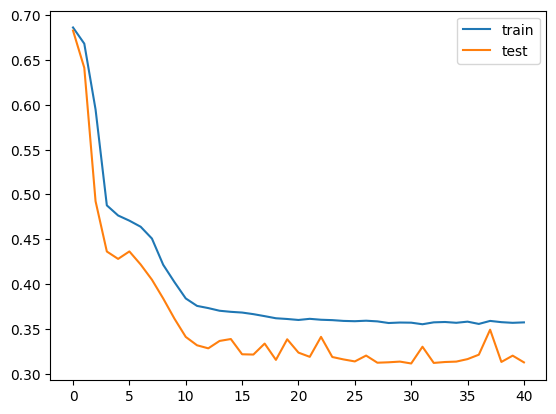

In [12]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
# adapted from https://stackoverflow.com/a/58598737
# given that the end goal is win probability over time and not predicting the victor,
# this is not a fair measure of the model
# especially difficult with overtime

from sklearn.metrics import confusion_matrix
from numpy import round

predictions = model.predict(X_test)
y_pred = round(predictions)

cm = confusion_matrix(y_test, y_pred)

total = sum(sum(cm))
accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : %.6f' % accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : %.6f' % sensitivity )

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : %.6f' % specificity)

1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step
Accuracy : 0.835725
Sensitivity : 0.919553
Specificity : 0.760758


In [14]:
import json

model.save("models/meter_ot_lstm16d1.keras")

# save columns to maintain shape during prediction in other scripts
with open("models/one_hot_columns.json", 'w') as f:
    json.dump(list(one_hot.columns), f)